<a href="https://colab.research.google.com/github/Hoanava/XLA/blob/main/S1mple_ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image
from google.colab import drive

In [ ]:
drive.mount('/content/drive')
# https://drive.google.com/file/d/15B7T1ILSrzfouUi6cvxj56JFNHXZpglO/view?usp=sharing
!unzip -uq "/content/drive/My Drive/s1mple_ocr.zip" -d "./"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
resnet50 = models.resnet50(pretrained=True)
resnet50 = resnet50.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
for param in resnet50.parameters():
    param.requires_grad = False

In [ ]:
dataset = '/content/simple_ocr/data'

train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'test')

# Batch size
bath_size = 32

# Number of classes
num_classes = len(os.listdir(valid_directory))  #10#2#257
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bath_size, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bath_size, shuffle=True)

4
{0: 'highlands', 1: 'others', 2: 'phuclong', 3: 'starbucks'}


In [ ]:
def predict(model, test_image_name):

    transform = image_transforms['test']

    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    
    test_image_tensor = transform(test_image)
    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)

        topk, topclass = ps.topk(3, dim=1)
        cls = idx_to_class[topclass.cpu().numpy()[0][0]]
        score = topk.cpu().numpy()[0][0]
        print("Predcition :", idx_to_class[topclass.cpu().numpy()[0][0]], ", Score: ", topk.cpu().numpy()[0][0])

Predcition : highlands , Score:  0.9972742


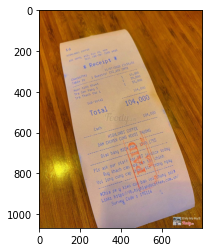

In [ ]:
model = torch.load('/content/simple_ocr/pretrained.pt')

predict(model, '/content/simple_ocr/sampledata/img3.jpeg')